В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

In [ ]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

warnings.filterwarnings('ignore')

Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

Исследуйте зависимость качества по метрике MAPE для моделей XGBoost, LightGBM, CatBoost, а так же градиентного бустинга из sklearn, в зависимости от количества деревьев, их максимальной глубины, шага обучения, l1 и l2 регуляризаций. При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий, масштаб осей так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментариии и выводы.

*Советы.*
* Используйте код с семинаров.
* Пока мы не умеем работать с признаком `zipcode`, удалите его из данных.

*Замечания.*
* Не забывайте, что для некоторых параметров стоит генерировать сетку значений при помощи `np.logspace`.

Для начала удалим zipcode и id из наших данных, так как с zipcode работать мы не умеем, а id не несет в себе никакую информацию. Любую работу с данными будем проделывать как с train, так и test данными, так как в последствии нам проверять качество модели на тестовых данных.

In [3]:
df_train = pd.read_csv('houses_train.csv')
df_test = pd.read_csv('houses_test.csv')
del df_train['zipcode'], df_train['id']
del df_test['zipcode'], df_test['id']

In [4]:
len(df_train)

15626

Обработаем колонку date для того, чтобы можно было вытащить из нее полезную информацию

In [5]:
df_train.date[0][:8]

'20151013'

In [6]:
df_train.date = np.array(list(map(lambda x : datetime.datetime.strptime(x[:8], '%Y%m%d'), df_train.date)))
df_test.date = np.array(list(map(lambda x : datetime.datetime.strptime(x[:8], '%Y%m%d'), df_test.date)))

Данные с датой обработаны, теперь было бы неплохо извлечь из них что-то полезное

In [7]:
unique_years = np.unique(np.array(list(map(lambda x : x.year, df_train.date))))
print(f'Годы продаж домов - {unique_years[0]} и {unique_years[1]}')

Годы продаж домов - 2015 и 2016


Text(0.5, 0, 'Месяц продажи')

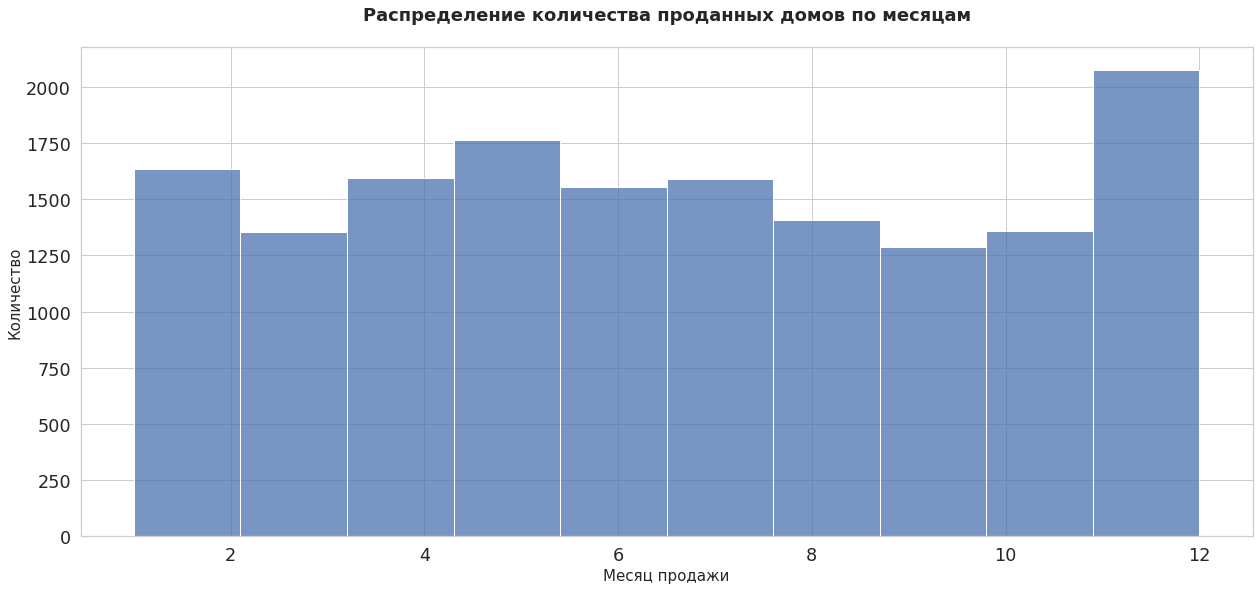

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize = (21, 9))
plt.grid(':')
sns.histplot(list(map(lambda x : x.month, df_train.date)), bins=10)
plt.title('Распределение количества проданных домов по месяцам\n', fontsize = 18, fontweight = 'bold')
plt.ylabel('Количество', fontsize = 15)
plt.xlabel('Месяц продажи', fontsize = 15)

In [9]:
df_train.groupby(['date']).mean()['price'].index[df_train.groupby(['date']).mean()['price'].argmax()]

Timestamp('2015-09-27 00:00:00')

Text(0.5, 0, 'Дата продажи')

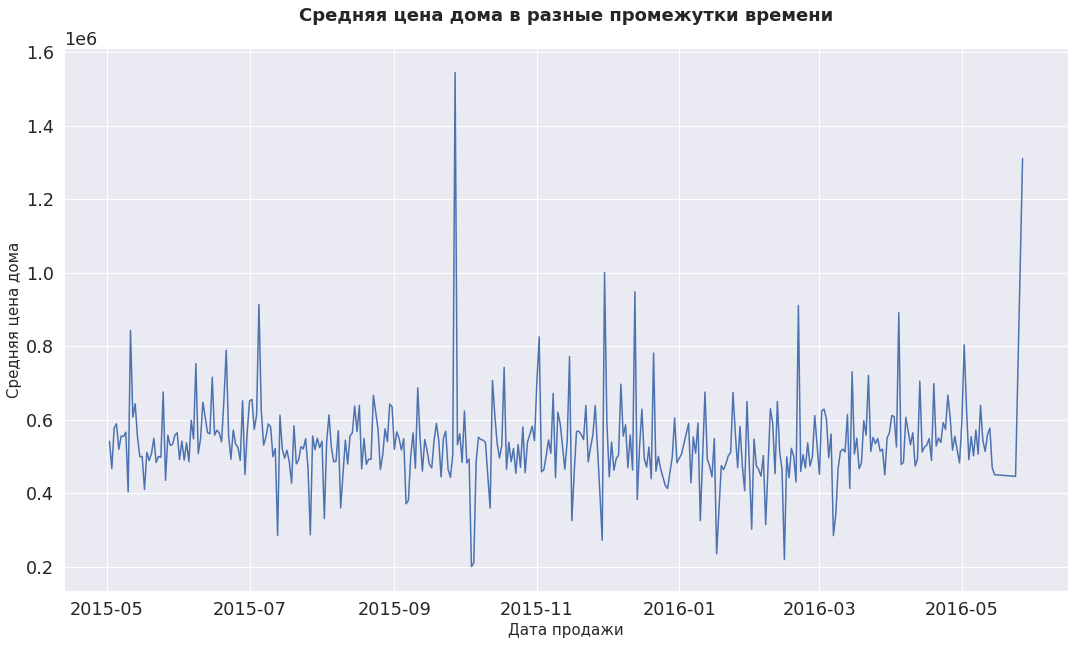

In [10]:
%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

ig = plt.figure(figsize = (18, 10))
plt.plot(df_train.groupby(['date']).mean()['price'].index, df_train.groupby(['date']).mean()['price'])
plt.title('Средняя цена дома в разные промежутки времени\n', fontsize = 18, fontweight = 'bold')
plt.ylabel('Средняя цена дома', fontsize = 15)
plt.xlabel('Дата продажи', fontsize = 15)

In [11]:
df_train.groupby(['date']).mean()['price'].index[df_train.groupby(['date']).mean()['price'].argmax()]

Timestamp('2015-09-27 00:00:00')

**Вывод:** Как видно по данным, продажи рассматриваются только за 2015 и 2016 год, поэтому создавать отдельные переменные, связанные с годом, скорее всего, не имеет смысла. Что касается месяцев, они также распределены равномерно, поэтому отдельно создавать колонку с месяцами не будем. Однако на последнем графике видно, что 2015-09-27 было резкое увеличение в ценах проданных домов. Этот факт можно зафиксировать в виде бинарной перменной.

In [12]:
df_train['big_price'] = np.array(list(map(lambda x : int(x.year == 2015 and x.month == 9 and x.day == 27), df_train.date)))
df_test['big_price'] = np.array(list(map(lambda x : int(x.year == 2015 and x.month == 9 and x.day == 27), df_test.date)))

Также создадим 2 важных на мой взгляд показателя: возраст дома и новизна дома. 

Возраст дома можно вычислить вычитав из года продажи год строительства дома.

А новизна дома - показатель, который показывает как давно был отреставрирован дом. 

In [13]:
df_train['age'] = np.array(list(map(lambda x : x.year, df_train.date))) - df_train.yr_built
df_test['age'] = np.array(list(map(lambda x : x.year, df_test.date))) - df_test.yr_built

In [14]:
df_train['restoration'] = np.array(list(map(lambda x : x.year, df_train.date))) - df_train.yr_renovated
df_test['restoration'] = np.array(list(map(lambda x : x.year, df_test.date))) - df_test.yr_renovated

Можно заметить, что некоторые дома нереставрировались, поэтому вместо рестоврации подставим возраст дома, что вполне логично

In [15]:
df_train.loc[(df_train['restoration'] == 2015) | (df_train['restoration'] == 2016), 'restoration'] = df_train.loc[(df_train['restoration'] == 2015) | (df_train['restoration'] == 2016), 'age']
df_test.loc[(df_test['restoration'] == 2015) | (df_test['restoration'] == 2016), 'restoration'] = df_test.loc[(df_test['restoration'] == 2015) | (df_test['restoration'] == 2016), 'age']

В целом, все полезные данные от дат мы извлекли, поэтому больше не нуждаемся в данных колонках. Удалим их

In [16]:
del df_train['date']
del df_test['date']

In [17]:
del df_train['yr_built']
del df_test['yr_built']
del df_train['yr_renovated']
del df_test['yr_renovated']

Также разделим переменную Grade на 3 уровня: 1-3 - плохой уровень, 4-7 - средний уровень, 8-13 - высокий уровень

In [18]:
df_train['bad_grades'] = list(map(int, (df_train['grade'] >= 1) & (df_train['grade'] <= 3)))
df_train['average_grades'] = list(map(int, (df_train['grade'] >= 4) & (df_train['grade'] <= 7)))
df_train['best_grades'] = list(map(int, (df_train['grade'] >= 8) & (df_train['grade'] <= 13)))

In [19]:
df_test['bad_grades'] = list(map(int, (df_test['grade'] >= 1) & (df_test['grade'] <= 3)))
df_test['average_grades'] = list(map(int, (df_test['grade'] >= 4) & (df_test['grade'] <= 7)))
df_test['best_grades'] = list(map(int, (df_test['grade'] >= 8) & (df_test['grade'] <= 13)))

In [20]:
del df_train['grade']
del df_test['grade']

Посмотрим на зависимость цены от количества этажей в доме

Text(0.5, 0, 'Количество этажей')

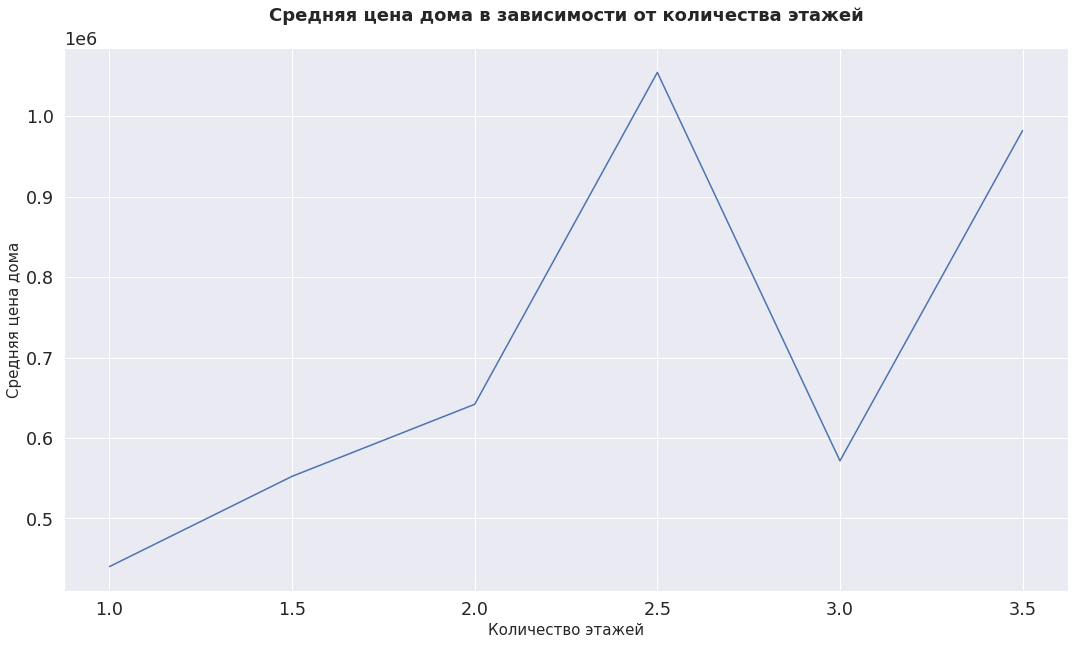

In [21]:
%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

fig = plt.figure(figsize = (18, 10))
plt.plot(df_train.groupby(['floors']).mean()['price'].index, df_train.groupby(['floors']).mean()['price'])
plt.title('Средняя цена дома в зависимости от количества этажей\n', fontsize = 18, fontweight = 'bold')
plt.ylabel('Средняя цена дома', fontsize = 15)
plt.xlabel('Количество этажей', fontsize = 15)

Как видно из данных нет четкой корреляции между количеством этажей и средней ценой на дом, поэтому логичнее данный признак сделать категориальным

In [22]:
onehot_encoder = OneHotEncoder(sparse=False)

train_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(np.array(df_train['floors']).reshape(-1, 1)))
test_categorical_columns = pd.DataFrame(onehot_encoder.transform(np.array(df_test['floors']).reshape(-1, 1)))

train_categorical_columns.columns = ['1_fl', '1.5_fl', '2_fl', '2.5_fl', '3_fl', '3.5_fl']
test_categorical_columns.columns = ['1_fl', '1.5_fl', '2_fl', '2.5_fl', '3_fl', '3.5_fl']

In [23]:
df_train = pd.concat([df_train, train_categorical_columns], axis=1)
df_test = pd.concat([df_test, test_categorical_columns], axis=1)

In [24]:
del df_train['floors']
del df_test['floors']

Объединим также количество спальных комнат и количество уборных комнат в один признак

In [25]:
df_train['rooms'] = df_train['bedrooms'] + df_train['bathrooms']
df_test['rooms'] = df_test['bedrooms'] + df_test['bathrooms']

In [26]:
del df_train['bedrooms'], df_train['bathrooms']
del df_test['bedrooms'], df_test['bathrooms']

In [27]:
df_train

,price,sqft_living,sqft_lot,waterfront,view,condition,sqft_above,sqft_basement,lat,long,...,bad_grades,average_grades,best_grades,1_fl,1.5_fl,2_fl,2.5_fl,3_fl,3.5_fl,rooms
0,221900.0,1180,5650,0,0,3,1180,0,47.5112,-122.257,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,4.00
1,538000.0,2570,7242,0,0,3,2170,400,47.7210,-122.319,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,5.25
2,604000.0,1960,5000,0,0,5,1050,910,47.5208,-122.393,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,7.00
3,510000.0,1680,8080,0,0,3,1680,0,47.6168,-122.045,...,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,5.00
4,257500.0,1715,6819,0,0,3,1715,0,47.3097,-122.327,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,5.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,1490,1126,0,0,3,1490,0,47.5699,-122.288,...,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,5.00
15622,610685.0,2520,6023,0,0,3,2520,0,47.5137,-122.167,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,6.50
15623,360000.0,1530,1131,0,0,3,1530,0,47.6993,-122.346,...,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,5.50
15624,400000.0,2310,5813,0,0,3,2310,0,47.5107,-122.362,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,6.50


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'price'], df_train['price'], test_size=0.33, random_state=42)

In [29]:
model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', random_state=42)

In [30]:
parameters_grid = {
    'n_estimators' : np.arange(50, 500),
    'max_depth' : np.arange(1, 11),
    'lambda' : sps.expon(loc=0, scale=1),
    'alpha' : sps.expon(loc=0, scale=1),
    'eta' : np.linspace(1e-3, 2, 1000)
}

In [31]:
# задаем стратегию кросс-валидации
ss = StratifiedKFold(n_splits=5)

# определяем поиск по сетке 
gs_xg = RandomizedSearchCV(
    # модель для обучения, в нашем случае XGBoost
    estimator=model_xg,
    # количество итераций поиска 
    n_iter=100,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # метрика качества, берем accuracy
    scoring='neg_mean_absolute_percentage_error',
    # GridSearch отлично параллелится, но и XGBoost параллелится
    n_jobs=-2,  
    # стратегия кросс-валидации
    cv=ss,  
     # сообщения с логами обучения: больше значение - больше сообщений
    verbose=False, 
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise',
    # seed для генератора случайных чисел
    random_state=42
)

In [32]:
gs_xg.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mape', gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          imp...
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465

In [33]:
cb_model = CatBoostRegressor(silent=True, eval_metric='MAPE', random_state=42)

In [34]:
parameters_grid = {
    'n_estimators' : np.arange(50, 600),
    'max_depth' : np.arange(1, 10),
    'l2_leaf_reg' : sps.expon(loc=0, scale=1),
    'eta' : np.linspace(1e-3, 1, 1000)
}

In [35]:
# задаем стратегию кросс-валидации
ss = StratifiedKFold(n_splits=5)

# определяем поиск по сетке 
gs_cb = RandomizedSearchCV(
    # модель для обучения, в нашем случае XGBoost
    estimator=cb_model,
    # количество итераций поиска 
    n_iter=100,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # метрика качества, берем accuracy
    scoring='neg_mean_absolute_percentage_error',
    # GridSearch отлично параллелится, но и XGBoost параллелится
    n_jobs=-2,  
    # стратегия кросс-валидации
    cv=ss,  
     # сообщения с логами обучения: больше значение - больше сообщений
    verbose=False, 
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise',
    # seed для генератора случайных чисел
    random_state=42
)

In [36]:
gs_cb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f3325a11070>,
                   n_iter=100, n_jobs=-2,
                   param_distributions={'eta': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.0...
       531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543,
       544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
       557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
       570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598, 599])},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error', verbose=False)

In [37]:
lgb_model = lgb.LGBMRegressor(random_state = 42)

In [38]:
parameters_grid = {
    'n_estimators' : np.arange(50, 600),
    'max_depth' : np.arange(1, 10),
    'reg_lambda' : sps.expon(loc=0, scale=1),
    'reg_alpha' : sps.expon(loc=0, scale=1),
    'learning_rate' : np.linspace(0.001, 1, 1000)
}

In [39]:
# задаем стратегию кросс-валидации
ss = StratifiedKFold(n_splits=5)

# определяем поиск по сетке 
gs_lgb = RandomizedSearchCV(
    # модель для обучения, в нашем случае XGBoost
    estimator=lgb_model,
    # количество итераций поиска 
    n_iter=100,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # метрика качества, берем accuracy
    scoring='neg_mean_absolute_percentage_error',
    # GridSearch отлично параллелится, но и XGBoost параллелится
    n_jobs=-1,  
    # стратегия кросс-валидации
    cv=ss,  
     # сообщения с логами обучения: больше значение - больше сообщений
    verbose=False, 
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise',
    # seed для генератора случайных чисел
    random_state=42
)

In [40]:
gs_lgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=LGBMRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024,...
       570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598, 599]),
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3325966ca0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f33259de730>},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error

In [41]:
sklearn_model = GradientBoostingRegressor(random_state=42)

In [42]:
parameters_grid = {
    'learning_rate': np.linspace(0.05, 0.5, 100),
    'n_estimators': np.arange(1, 600),
    'max_depth': np.arange(3, 11)
}

In [43]:
# задаем стратегию кросс-валидации
ss = StratifiedKFold(n_splits=5)

# определяем поиск по сетке 
gs_skl = RandomizedSearchCV(
    # модель для обучения, в нашем случае XGBoost
    estimator=sklearn_model,
    # количество итераций поиска 
    n_iter=100,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # метрика качества, берем accuracy
    scoring='neg_mean_absolute_percentage_error',
    # GridSearch отлично параллелится, но и XGBoost параллелится
    n_jobs=-1,  
    # стратегия кросс-валидации
    cv=ss,  
     # сообщения с логами обучения: больше значение - больше сообщений
    verbose=False, 
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise',
    # seed для генератора случайных чисел
    random_state=42
)

In [44]:
gs_skl.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05      , 0.05454545, 0.05909091, 0.06363636, 0.06818182,
       0.07272727, 0.07727273, 0.08181818, 0.08636364, 0.09090909,
       0.09545455, 0.1       , 0.10454545,...
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
       573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
       599])},
                   random_state=42,
                   scoring='neg_mean_abs

Смотрим, какие параметры получились, после кросс-валидации.

In [45]:
gs_xg.best_params_

{'alpha': 1.052904084582266,
 'eta': 0.055027027027027026,
 'lambda': 1.9885295716582227,
 'max_depth': 8,
 'n_estimators': 317}

In [46]:
gs_cb.best_params_

{'eta': 0.081,
 'l2_leaf_reg': 0.2994577768406861,
 'max_depth': 8,
 'n_estimators': 437}

In [47]:
gs_lgb.best_params_

{'learning_rate': 0.099,
 'max_depth': 9,
 'n_estimators': 518,
 'reg_alpha': 1.3958378736630772,
 'reg_lambda': 1.5681954162211487}

In [48]:
gs_skl.best_params_

{'n_estimators': 352, 'max_depth': 7, 'learning_rate': 0.05}

Оценка MAPE:

In [49]:
mean_absolute_percentage_error(gs_cb.predict(X_test), y_test) 

0.11885128048119055

In [50]:
mean_absolute_percentage_error(gs_xg.predict(X_test), y_test) 

0.12108347329390266

In [51]:
mean_absolute_percentage_error(gs_lgb.predict(X_test), y_test) 

0.12350390990801297

In [52]:
mean_absolute_percentage_error(gs_skl.predict(X_test), y_test) 

0.12175921282691221

Давайте теперь исследуем зависимость гиперпараметров от MAPE:

In [53]:
mape_test_xg_depth = []
mape_test_cb_depth = []
mape_test_lgb_depth = []
mape_test_skl_depth = []

for depth in np.arange(2, 14):
    model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', alpha = gs_xg.best_params_['alpha'], eta=gs_xg.best_params_['eta'], 
                         reg_lambda = gs_xg.best_params_['lambda'], n_estimators = gs_xg.best_params_['n_estimators'], 
                            max_depth = depth, random_state=42)
    
    model_cb = CatBoostRegressor(silent=True, eval_metric='MAPE', random_state=42, eta=gs_cb.best_params_['eta'], 
                                 l2_leaf_reg= gs_cb.best_params_['l2_leaf_reg'], n_estimators = gs_cb.best_params_['n_estimators'], 
                                 max_depth=depth) 
    
    model_skl = GradientBoostingRegressor(random_state = 42,
                                          learning_rate=gs_skl.best_params_['learning_rate'],
                                          n_estimators=gs_skl.best_params_['n_estimators'], 
                                          max_depth = depth)
    
    model_lgb = lgb.LGBMRegressor(random_state = 42, reg_alpha=gs_lgb.best_params_['reg_alpha'], 
                                  reg_lambda=gs_lgb.best_params_['reg_lambda'],
                                  learning_rate=gs_lgb.best_params_['learning_rate'],
                                  n_estimators=gs_lgb.best_params_['n_estimators'], max_depth = depth)
    
    
    model_cb.fit(X_train, y_train)
    model_xg.fit(X_train, y_train)
    model_lgb.fit(X_train, y_train)
    model_skl.fit(X_train, y_train)
    
    mape_test_xg_depth.append(mean_absolute_percentage_error(model_xg.predict(X_test), y_test))
    mape_test_cb_depth.append(mean_absolute_percentage_error(model_cb.predict(X_test), y_test))
    mape_test_lgb_depth.append(mean_absolute_percentage_error(model_lgb.predict(X_test), y_test))
    mape_test_skl_depth.append(mean_absolute_percentage_error(model_skl.predict(X_test), y_test))       

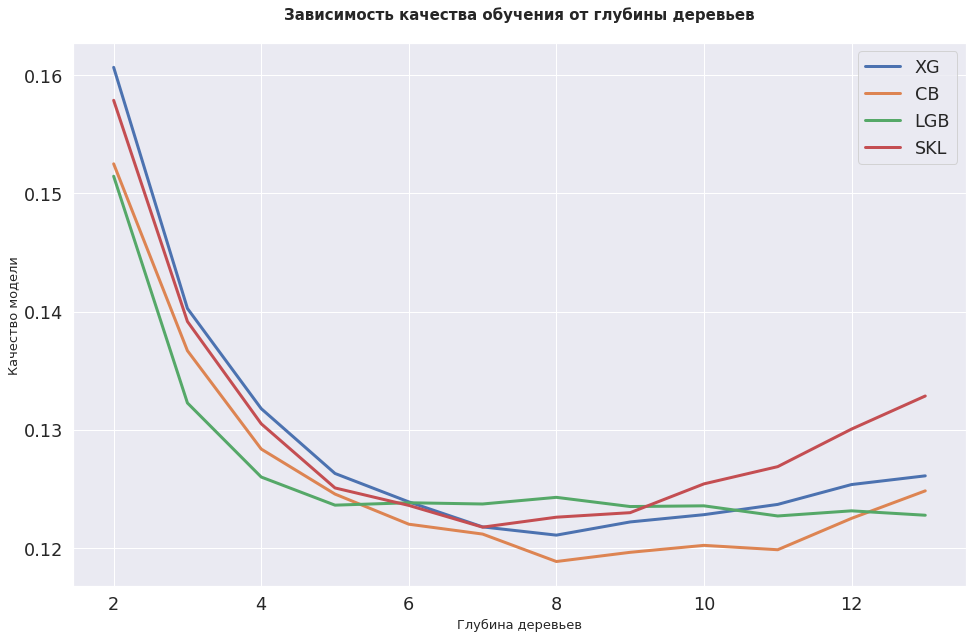

In [54]:
figure = plt.figure(figsize = (16, 10))

plt.plot(np.arange(2, 14), mape_test_xg_depth, label = 'XG', linewidth = 3)
plt.plot(np.arange(2, 14), mape_test_cb_depth, label = 'CB', linewidth = 3)
plt.plot(np.arange(2, 14), mape_test_lgb_depth, label = 'LGB', linewidth = 3)
plt.plot(np.arange(2, 14), mape_test_skl_depth, label = 'SKL', linewidth = 3)

plt.title('Зависимость качества обучения от глубины деревьев\n', fontsize = 15, fontweight = 'bold')
plt.xlabel('Глубина деревьев', fontsize = 13)
plt.ylabel('Качество модели', fontsize = 13)

plt.legend()

По нашему графику мы видим, что при больших глубинах происходит переобучение. Также по графику видно, что лучше всех себя показывает CatBoost. Остальные вроде плюс минус имеют похожую ситуацию, но обычный Градиентный спуск переобучается быстрее всех.

In [55]:
learning_rate_grid = np.linspace(0.01, 1, 40)
mape_test_xg_lr = []
mape_test_cb_lr = []
mape_test_lgb_lr = []
mape_test_skl_lr = []

for lr in tqdm(learning_rate_grid):
    model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', alpha = gs_xg.best_params_['alpha'], eta=lr, 
                         reg_lambda = gs_xg.best_params_['lambda'], n_estimators = gs_xg.best_params_['n_estimators'], 
                            max_depth = gs_xg.best_params_['max_depth'], random_state=42)
    
    model_cb = CatBoostRegressor(silent=True, eval_metric='MAPE', random_state=42, eta=lr, 
                                 l2_leaf_reg= gs_cb.best_params_['l2_leaf_reg'], n_estimators = gs_cb.best_params_['n_estimators'], 
                                 max_depth=gs_cb.best_params_['max_depth']) 
    
    model_skl = GradientBoostingRegressor(random_state = 42,
                                          learning_rate=lr,
                                          n_estimators=gs_skl.best_params_['n_estimators'], 
                                          max_depth = gs_skl.best_params_['max_depth'])
    
    model_lgb = lgb.LGBMRegressor(random_state = 42, reg_alpha=gs_lgb.best_params_['reg_alpha'], 
                                  reg_lambda=gs_lgb.best_params_['reg_lambda'],
                                  learning_rate=lr,
                                  n_estimators=gs_lgb.best_params_['n_estimators'], 
                                  max_depth = gs_lgb.best_params_['max_depth'])
    
    
    model_cb.fit(X_train, y_train)
    model_xg.fit(X_train, y_train)
    model_lgb.fit(X_train, y_train)
    model_skl.fit(X_train, y_train)
    
    mape_test_xg_lr.append(mean_absolute_percentage_error(model_xg.predict(X_test), y_test))
    mape_test_cb_lr.append(mean_absolute_percentage_error(model_cb.predict(X_test), y_test))
    mape_test_lgb_lr.append(mean_absolute_percentage_error(model_lgb.predict(X_test), y_test))
    mape_test_skl_lr.append(mean_absolute_percentage_error(model_skl.predict(X_test), y_test))       

  0%|          | 0/40 [00:00<?, ?it/s]

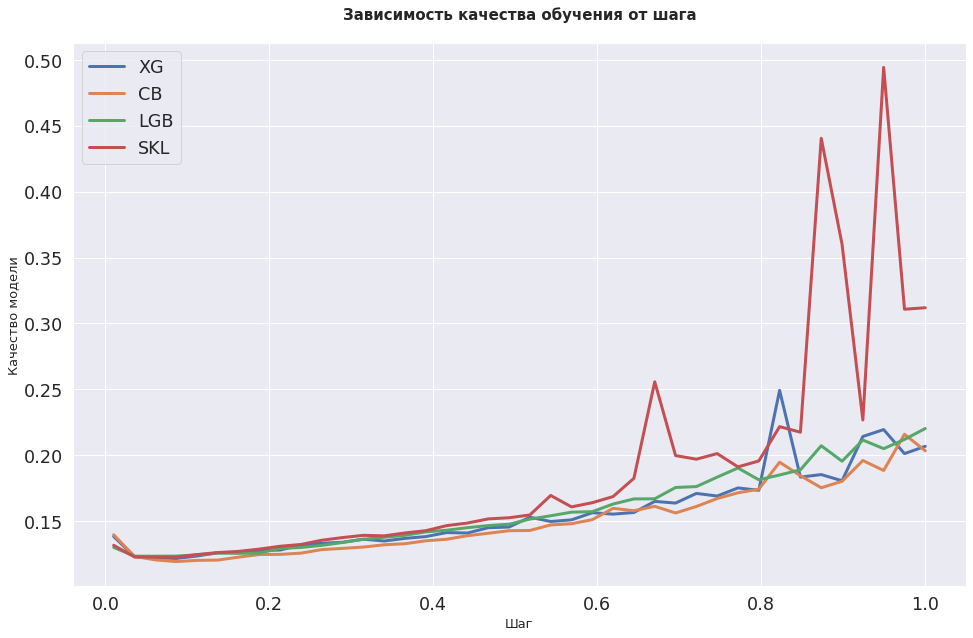

In [56]:
figure = plt.figure(figsize = (16, 10))

plt.plot(learning_rate_grid, mape_test_xg_lr, label = 'XG', linewidth = 3)
plt.plot(learning_rate_grid, mape_test_cb_lr, label = 'CB', linewidth = 3)
plt.plot(learning_rate_grid, mape_test_lgb_lr, label = 'LGB', linewidth = 3)
plt.plot(learning_rate_grid, mape_test_skl_lr, label = 'SKL', linewidth = 3)

plt.title('Зависимость качества обучения от шага\n', fontsize = 15, fontweight = 'bold')
plt.xlabel('Шаг', fontsize = 13)
plt.ylabel('Качество модели', fontsize = 13)

plt.legend()

Тут мы видим, что лучшее качество имеет опять Catboost, хотя XGboost и Lgb тоже неплохи. Градиентный спуск себя показывает хуже всех. Можно заметить, что с увеличение шага, качество ухудшается, что в принципе логично.

In [57]:
l2_grid = sorted(sps.expon(loc=0, scale=1).rvs(size=40))
mape_test_xg_l2 = []
mape_test_cb_l2 = []
mape_test_lgb_l2 = []

for l2 in tqdm(l2_grid):
    model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', alpha = gs_xg.best_params_['alpha'], eta=gs_xg.best_params_['eta'], 
                         reg_lambda = l2, n_estimators = gs_xg.best_params_['n_estimators'], 
                            max_depth = gs_xg.best_params_['max_depth'], random_state=42)
    
    model_cb = CatBoostRegressor(silent=True, eval_metric='MAPE', random_state=42, eta=gs_cb.best_params_['eta'], 
                                 l2_leaf_reg=l2, n_estimators = gs_cb.best_params_['n_estimators'], 
                                 max_depth=gs_cb.best_params_['max_depth']) 
    
    model_lgb = lgb.LGBMRegressor(random_state = 42, reg_alpha=gs_lgb.best_params_['reg_alpha'], 
                                  reg_lambda=l2,
                                  learning_rate=gs_lgb.best_params_['learning_rate'],
                                  n_estimators=gs_lgb.best_params_['n_estimators'], 
                                  max_depth = gs_lgb.best_params_['max_depth'])
    
    
    model_cb.fit(X_train, y_train)
    model_xg.fit(X_train, y_train)
    model_lgb.fit(X_train, y_train)
    
    mape_test_xg_l2.append(mean_absolute_percentage_error(model_xg.predict(X_test), y_test))
    mape_test_cb_l2.append(mean_absolute_percentage_error(model_cb.predict(X_test), y_test))
    mape_test_lgb_l2.append(mean_absolute_percentage_error(model_lgb.predict(X_test), y_test))

  0%|          | 0/40 [00:00<?, ?it/s]

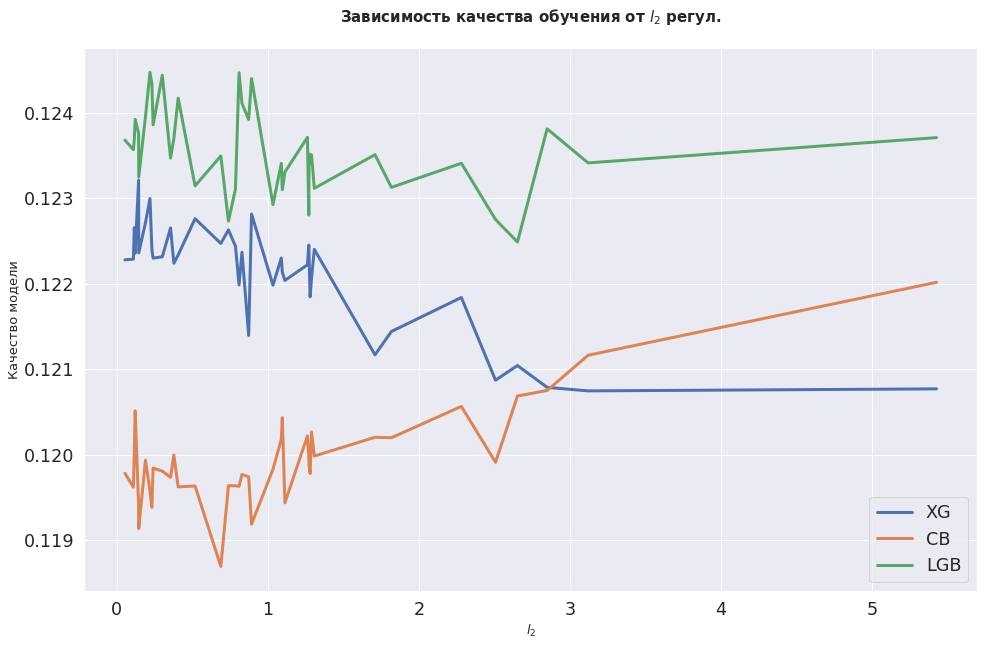

In [58]:
figure = plt.figure(figsize = (16, 10))

plt.plot(l2_grid, mape_test_xg_l2, label = 'XG', linewidth = 3)
plt.plot(l2_grid, mape_test_cb_l2, label = 'CB', linewidth = 3)
plt.plot(l2_grid, mape_test_lgb_l2, label = 'LGB', linewidth = 3)

plt.title('Зависимость качества обучения от $l_2$ регул.\n', fontsize = 15, fontweight = 'bold')
plt.xlabel('$l_2$', fontsize = 13)
plt.ylabel('Качество модели', fontsize = 13)

plt.legend()

Тут мы видим, что наилучшее качество имеет опять CatBoost. Также мы видим, что CatBoost принимает маленькие значения при малых $l_2$, в отличии от других моделей. Хуже всего показывает LGB.

In [59]:
l1_grid = sorted(sps.expon(loc=0, scale=1).rvs(size=40))
mape_test_xg_l1 = []
mape_test_lgb_l1 = []

for l1 in tqdm(l1_grid):
    model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', alpha = l1, eta=gs_xg.best_params_['eta'], 
                            reg_lambda = gs_xg.best_params_['lambda'], n_estimators = gs_xg.best_params_['n_estimators'], 
                            max_depth = gs_xg.best_params_['max_depth'], random_state=42)
    

    model_lgb = lgb.LGBMRegressor(random_state = 42, reg_alpha=l1, 
                                  reg_lambda=gs_lgb.best_params_['reg_lambda'],
                                  learning_rate=gs_lgb.best_params_['learning_rate'],
                                  n_estimators=gs_lgb.best_params_['n_estimators'], 
                                  max_depth = gs_lgb.best_params_['max_depth'])
    
    
    model_xg.fit(X_train, y_train)
    model_lgb.fit(X_train, y_train)
    
    mape_test_xg_l1.append(mean_absolute_percentage_error(model_xg.predict(X_test), y_test))
    mape_test_lgb_l1.append(mean_absolute_percentage_error(model_lgb.predict(X_test), y_test))

  0%|          | 0/40 [00:00<?, ?it/s]

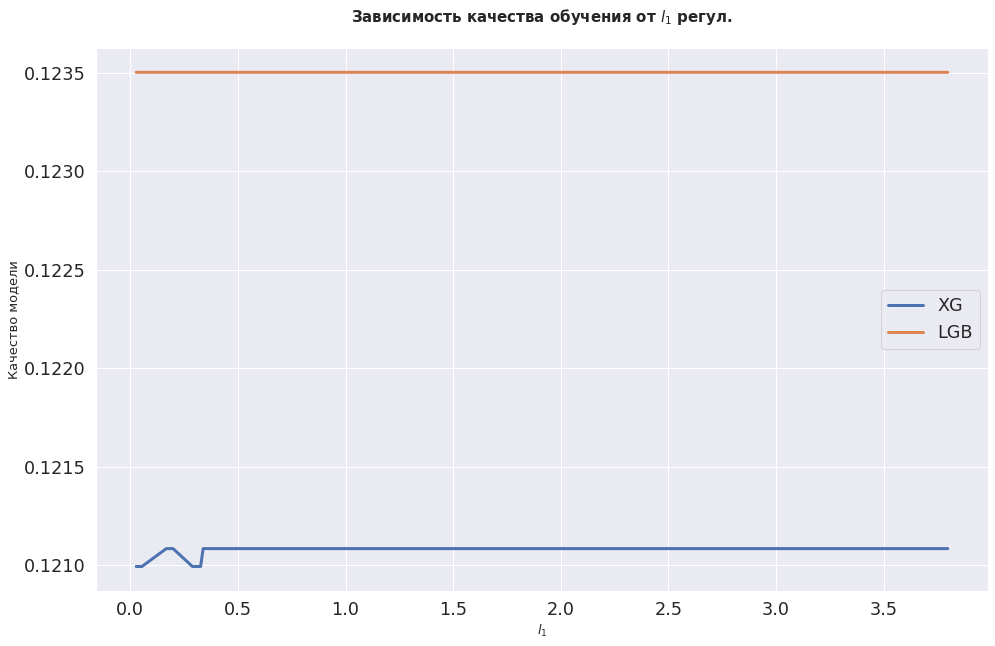

In [60]:
figure = plt.figure(figsize = (16, 10))

plt.plot(l1_grid, mape_test_xg_l1, label = 'XG', linewidth = 3)
plt.plot(l1_grid, mape_test_lgb_l1, label = 'LGB', linewidth = 3)

plt.title('Зависимость качества обучения от $l_1$ регул.\n', fontsize = 15, fontweight = 'bold')
plt.xlabel('$l_1$', fontsize = 13)
plt.ylabel('Качество модели', fontsize = 13)

plt.legend()

Ну тут явное доминирование XGboost. Хотя так может показаться из-за масштаба (отличие тут до сотых). Но все же стабильно XGboost показывает себя лучше, чем LGB.

In [61]:
model_xg = XGBRegressor(use_label_encoder=False, eval_metric='mape', alpha = gs_xg.best_params_['alpha'], eta=gs_xg.best_params_['eta'], 
                         reg_lambda = gs_xg.best_params_['lambda'], n_estimators = 600, 
                            max_depth = gs_xg.best_params_['max_depth'], random_state=42)
    
model_cb = CatBoostRegressor(silent=True, eval_metric='MAPE', random_state=42, eta=gs_cb.best_params_['eta'], 
                             l2_leaf_reg= gs_cb.best_params_['l2_leaf_reg'], n_estimators = 600, 
                             max_depth=gs_cb.best_params_['max_depth']) 

model_skl = GradientBoostingRegressor(random_state = 42,
                                      learning_rate=gs_skl.best_params_['learning_rate'],
                                      n_estimators=600, 
                                      max_depth = gs_skl.best_params_['max_depth'])

model_lgb = lgb.LGBMRegressor(random_state = 42, reg_alpha=gs_lgb.best_params_['reg_alpha'], 
                              reg_lambda=gs_lgb.best_params_['reg_lambda'],
                              learning_rate=gs_lgb.best_params_['learning_rate'],
                              n_estimators=600, 
                              max_depth = gs_lgb.best_params_['max_depth'])

In [62]:
model_lgb.fit(X_train, y_train)
model_xg.fit(X_train, y_train)
model_cb.fit(X_train, y_train)
model_skl.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, n_estimators=600,
                          random_state=42)

In [63]:
mape_test_cb_est = list(map(lambda x: mean_absolute_percentage_error(y_test, x), model_cb.staged_predict(X_test)))
mape_test_skl_est = list(map(lambda x: mean_absolute_percentage_error(y_test, x), model_skl.staged_predict(X_test)))

In [64]:
mape_test_xg_est = []
mape_test_lgb_est = []

for i in range(600):
    mape_test_xg_est.append(mean_absolute_percentage_error(y_test, model_xg.predict(X_test, iteration_range=(0, i))))
    mape_test_lgb_est.append(mean_absolute_percentage_error(y_test, model_lgb.predict(X_test, num_iteration=i)))


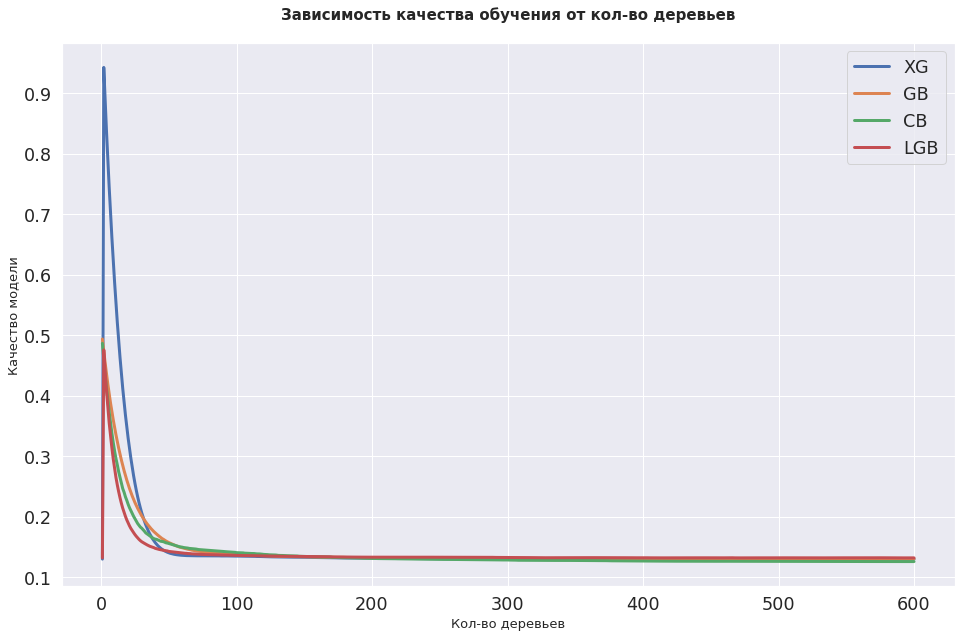

In [65]:
figure = plt.figure(figsize = (16, 10))

plt.plot(np.arange(600) + 1, mape_test_xg_est, label = 'XG', linewidth = 3)
plt.plot(np.arange(600) + 1, mape_test_skl_est, label = 'GB', linewidth = 3)
plt.plot(np.arange(600) + 1, mape_test_cb_est, label = 'CB', linewidth = 3)
plt.plot(np.arange(600) + 1, mape_test_lgb_est, label = 'LGB', linewidth = 3)

plt.title('Зависимость качества обучения от кол-во деревьев\n', fontsize = 15, fontweight = 'bold')
plt.xlabel('Кол-во деревьев', fontsize = 13)
plt.ylabel('Качество модели', fontsize = 13)

plt.legend()

В данной ситуации мы видим, что при больших количествах n_estimators, у нас качество уменьшается. Тут мы видим, что все же CatBoost находится ниже всех моделей (т.е. имеет наилучшее качество).

**Вывод:**
1) Подобрав оптимальные параметры для каждой модели и посчитав качество, мы видим, что самая мощная модель является CatBoost в данной задаче.

2) По графикам мы видим, что CatBoost практически все время имеет наилучшее качество. XGboost тоже неплохо себя показывает. А вот обычный градиентный спуск показывает себя хуже всего.